## Synthetic Spectrum

Here we test VAMP on a synthetic spectrum of a massive central galaxy in the s43 SIMBA simulation, generated using [Pygad](https://bitbucket.org/broett/pygad/src/master/) for the CII 1036 Angstrom line.


In [1]:
import numpy as np
import pandas as pd
import h5py

%matplotlib inline
import matplotlib.pyplot as plt

import vpfits

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelextrema

import pymc as mc
from pymc.Matplot import plot
from scipy import stats
from copy import copy
import gc

In [2]:
data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')
data.keys()

[u'density_col',
 u'flux',
 u'noise',
 u'tau',
 u'temp',
 u'velocity',
 u'wavelength']

In [3]:
wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['flux'][:]
taus = data['tau'][:]

In [4]:
vpfit = vpfits.VPfit()

In [5]:
min_region_width = 2
regions, region_pixels = vpfits.compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


In [6]:
region_arrays = []
for region in region_pixels:
    start = region[0]
    end = region[1]
    region_arrays.append([wavelength[start:end], taus[start:end], flux[start:end], noise[start:end]])

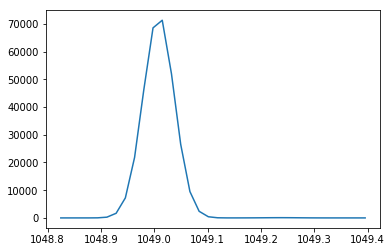

In [7]:
# plot the optical depth for the 1st region 
# (the 0th region has a doublet)

plt.plot(region_arrays[1][0], region_arrays[1][1])
plt.show()

In [8]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

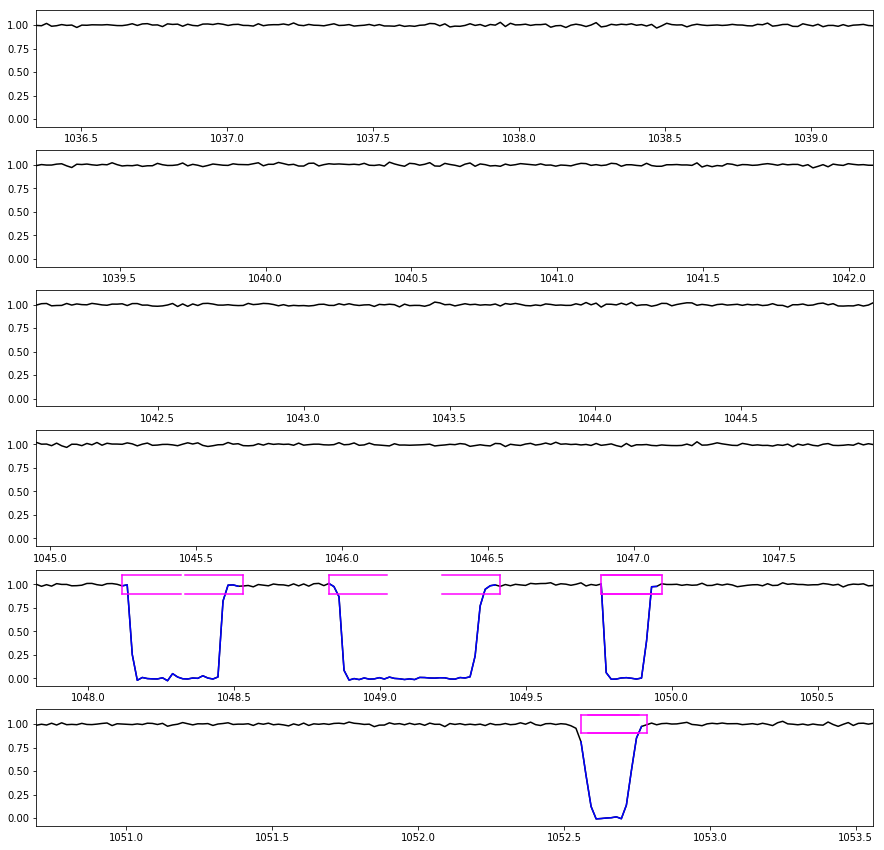

In [9]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(wavelength, flux, c='black')
    
    ax[n].set_xlim(wavelength[lower_lim], wavelength[upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[2], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(wavelength[start], ax[n], 'left')
        plot_bracket(wavelength[end], ax[n], 'right')

plt.show()

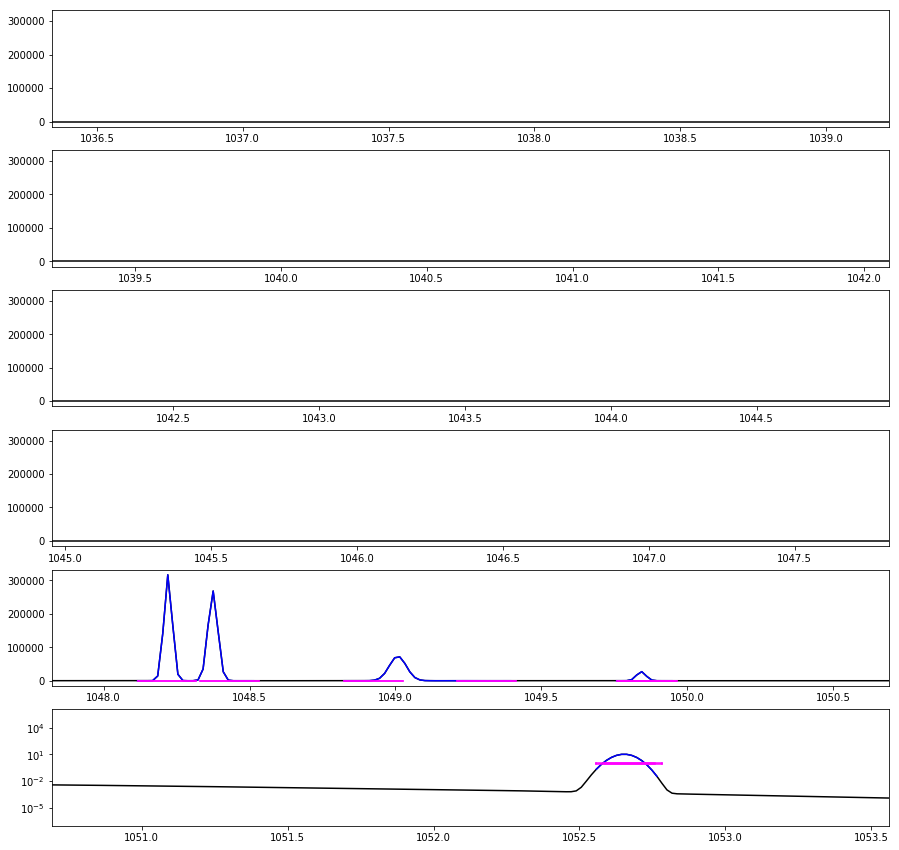

In [10]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))
plt.yscale('log')

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(wavelength, taus, c='black')
    
    ax[n].set_xlim(wavelength[lower_lim], wavelength[upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(wavelength[start], ax[n], 'left')
        plot_bracket(wavelength[end], ax[n], 'right')

plt.show()

Setting initial number of lines to: 1
Old BIC value of -16.46 is greater than the current -24.87.
Increasing the number of lines to: 3
Old BIC value of -24.87 is greater than the current -159.95.
Increasing the number of lines to: 4
Old BIC value of -159.95 is greater than the current -177.55.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


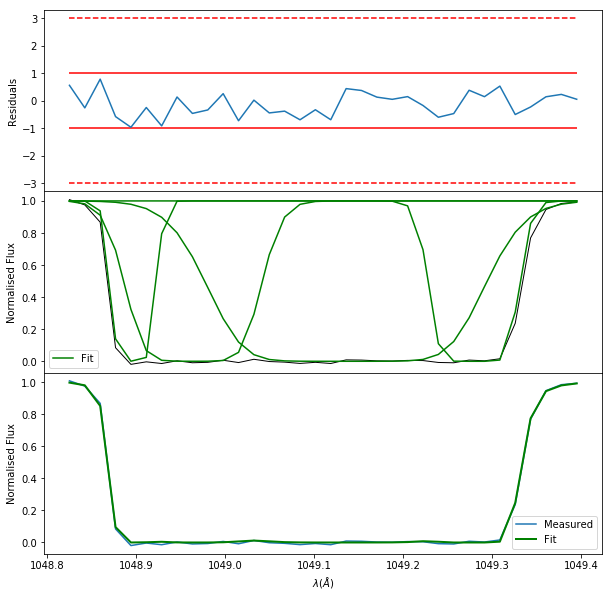

7380

In [11]:
iterations = 10000
thin = 15
burn = 1000
i = 1
wavelengths = region_arrays[i][0]
fluxes_orig = region_arrays[i][2]
fluxes = region_arrays[i][2]
noise = region_arrays[i][3]
n = argrelextrema(gaussian_filter(fluxes_orig, 3), np.less)[0].shape[0]
"""Smooth the spectra with a gaussian and find the number of local minima.
as a safety precaucion, set the initial guess for number of lines to 1 if
there are less than 4 local minima."""
if n < 4:
    n = 1
first = True
finished = False
print "Setting initial number of lines to: {}".format(n)
while not finished:
    bic_array = []
    for _ in range(3):
        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map = mc.MAP(vpfit_2.model)
        vpfit_2.mcmc = mc.MCMC(vpfit_2.model)
        vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
        vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
        vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
        vpfit_2.mcmc.sample(iter=2000, burn=burn, thin=thin, progress_bar=False)
        vpfit_2.map.fit(iterlim=iterations, tol=1e-3)
        bic_array.append(vpfit_2.map.BIC)
    if first:
        first = False
        n += 1
        bic_old = vpfit_2.map.BIC
        vpfit_old = copy(vpfit_2)
        del vpfit_2
    else:
        if bic_old > np.average(bic_array):
            print "Old BIC value of {:.2f} is greater than the current {:.2f}.".format(bic_old, np.average(bic_array))
            print "Increasing the number of lines to: {}".format(n+1)
            n += 1
            bic_old = np.average(bic_array)
            vpfit_old = copy(vpfit_2)
            del vpfit_2
        else:
            print "BIC increased with increasing the line number, stopping."
            print "Final n={}.".format(n-1)
            finished = True
vpfit_old.mcmc.sample(iter=15000, burn=burn, thin=thin, progress_bar=False)
start = region_pixels[i][0]
end = region_pixels[i][1]
vpfit_old.plot(wavelengths, fluxes_orig, n=n-1, start_pix=start, end_pix=end)
del vpfit_2
gc.collect()

In [12]:
for i in range(len(vpfit_old.estimated_variables)):
    print vpfit_old.estimated_variables[i]['height'].value

12.248924140316655
7.80506456967023
8.513012927459757
9.829488852948858


The output heights of the lines in this region are much lower than the optical depth profile plotted above?